In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import time

**Grid Generation**

In [18]:
def generate_interior_grid(Nx, Ny, Lx=1.0, Ly=1.0):
    """
    Generates the interior grid points for the domain [0, Lx] x [0, Ly].

    Parameters:
    - Nx (int): Number of interior grid points along x.
    - Ny (int): Number of interior grid points along y.
    - Lx (float): Length of the domain in x-direction.
    - Ly (float): Length of the domain in y-direction.

    Returns:
    - X, Y (2D arrays): Coordinates of interior grid points.
    """
    dx = Lx / (Nx + 1)
    dy = Ly / (Ny + 1)
    x = np.linspace(dx, Lx - dx, Nx)  # Exclude boundaries
    y = np.linspace(dy, Ly - dy, Ny)  # Exclude boundaries
    X, Y = np.meshgrid(x, y, indexing='ij')  # Shape: (Nx, Ny)
    return X, Y

**Matrix Assembly**

In [19]:
def assemble_matrix(Nx, Ny, h):
    """
    Assembles the sparse matrix A for the discrete Poisson equation.

    Parameters:
    - Nx (int): Number of interior points along x.
    - Ny (int): Number of interior points along y.
    - h (float): Grid spacing (assumed uniform in x and y).

    Returns:
    - A (csr_matrix): Sparse matrix representing the discrete Laplacian.
    """
    N = Nx * Ny
    A = lil_matrix((N, N))

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i  # Linear index
            A[k, k] = 4.0 / h**2  # Diagonal entry

            # Left neighbor
            if i > 0:
                A[k, k - 1] = -1.0 / h**2
            # Right neighbor
            if i < Nx - 1:
                A[k, k + 1] = -1.0 / h**2
            # Bottom neighbor
            if j > 0:
                A[k, k - Nx] = -1.0 / h**2
            # Top neighbor
            if j < Ny - 1:
                A[k, k + Nx] = -1.0 / h**2

    return A.tocsr()


**Assembling the Right-Hand Side Vector**

In [20]:
def assemble_rhs(Nx, Ny, X, Y, f_exact, g_func, h, Lx, Ly):
    """
    Assembles the right-hand side vectors b and f considering boundary conditions.

    Parameters:
    - Nx, Ny (int): Number of interior points along x and y.
    - X, Y (2D arrays): Coordinates of interior grid points.
    - f_exact (2D array): Exact source term at interior grid points.
    - g_func (callable): Boundary condition function g(x, y).
    - h (float): Grid spacing.
    - Lx, Ly (float): Domain lengths.

    Returns:
    - b (1D array): Boundary contributions.
    - f (1D array): Source term contributions.
    """
    N = Nx * Ny
    b = np.zeros(N)
    f = np.zeros(N)

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i  # Linear index
            f[k] = f_exact[i, j] * h**2  # Source term contribution

            # Check if the current point is adjacent to a boundary
            # Left boundary (x=0)
            if i == 0:
                b[k] += g_func(0, Y[i, j]) / h**2
            # Right boundary (x=Lx)
            if i == Nx - 1:
                b[k] += g_func(Lx, Y[i, j]) / h**2
            # Bottom boundary (y=0)
            if j == 0:
                b[k] += g_func(X[i, j], 0) / h**2
            # Top boundary (y=Ly)
            if j == Ny - 1:
                b[k] += g_func(X[i, j], Ly) / h**2

    return b, f


**Solving the Poisson Equation Numerically**

In [21]:
def solve_poisson(Nx, Ny, Lx=1.0, Ly=1.0, f_exact=None, g_func=lambda x, y: 0.0):
    """
    Solves the 2D Poisson equation with Dirichlet boundary conditions.

    Parameters:
    - Nx (int): Number of interior points along x.
    - Ny (int): Number of interior points along y.
    - Lx, Ly (float): Domain lengths.
    - f_exact (2D array): Exact source term at interior grid points.
    - g_func (callable): Boundary condition function g(x, y).

    Returns:
    - X, Y (2D arrays): Coordinates of interior grid points.
    - U (2D array): Numerical solution u at interior grid points.
    - solve_time (float): Time taken to solve the linear system.
    """
    # Generate grid
    X, Y = generate_interior_grid(Nx, Ny, Lx, Ly)
    h = Lx / (Nx + 1)  # Since Nx is the number of interior points

    # Assemble matrix A
    A = assemble_matrix(Nx, Ny, h)

    # Assemble right-hand side vectors b and f
    b, f = assemble_rhs(Nx, Ny, X, Y, f_exact, g_func, h, Lx, Ly)

    # Total right-hand side
    rhs = b + f

    # Solve the linear system
    start_time = time.time()
    u = spsolve(A, rhs)
    end_time = time.time()
    solve_time = end_time - start_time

    # Reshape solution to 2D grid
    U = u.reshape((Nx, Ny))

    return X, Y, U, solve_time

**Defining the Exact Solution**

In [22]:
def exact_solution(X, Y):
    """
    Exact solution u_ex(x, y) = sin^2(pi x) sin^2(pi y)

    Parameters:
    - X, Y (2D arrays): Coordinates of interior grid points.

    Returns:
    - U_exact (2D array): Exact solution at interior grid points.
    """
    return np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2

**Defining and Corresponding Right-Hand Side**

In [23]:
def exact_rhs(X, Y):
    """
    Right-hand side function f(x, y) corresponding to the exact solution.

    Parameters:
    - X, Y (2D arrays): Coordinates of interior grid points.

    Returns:
    - f_exact (2D array): Exact source term at interior grid points.
    """
    pi = np.pi
    term1 = 2 * pi**2 * np.cos(2 * pi * X) * (np.sin(pi * Y)**2)
    term2 = 2 * pi**2 * (np.sin(pi * X)**2) * np.cos(2 * pi * Y)
    return term1 + term2

**Computing Relative Error**

In [24]:
def compute_relative_error(U_num, U_exact):
    """
    Computes the relative error in the maximum norm.

    Parameters:
    - U_num (2D array): Numerical solution.
    - U_exact (2D array): Exact solution.

    Returns:
    - rel_error (float): Relative error in maximum norm.
    """
    error = np.abs(U_num - U_exact)
    rel_error = np.max(error) / np.max(np.abs(U_exact))
    return rel_error

**Convergency**

In [27]:
def perform_convergence_study():
    """
    Performs a convergence study to validate the finite difference solver.
    """
    # Define exact solution and corresponding f(x, y)
    u_ex_func = exact_solution
    f_ex_func = exact_rhs

    # Define boundary condition function based on exact solution
    # Since u_ex = 0 on boundaries, homogeneous Dirichlet
    g_homogeneous = lambda x, y: 0.0

    # Grid sizes for convergence study
    grid_sizes = [10, 20, 40, 80]  # Number of interior points along each axis
    errors = []
    hs = []
    solve_times = []

    for N in grid_sizes:
        Nx, Ny = N, N  # Use square grids for simplicity
        Lx, Ly = 1.0, 1.0

        # Generate grid and compute exact solution
        X, Y = generate_interior_grid(Nx, Ny, Lx, Ly)
        U_exact = u_ex_func(X, Y)

        # Compute exact f
        f_exact = f_ex_func(X, Y)

        # Solve Poisson equation numerically
        U_num, solve_time = None, None
        try:
            X_num, Y_num, U_num, solve_time = solve_poisson(
                Nx, Ny, Lx, Ly,
                f_exact=f_exact,
                g_func=g_homogeneous
            )
        except Exception as e:
            print(f"Error solving Poisson equation for grid size {Nx}x{Ny}: {e}")
            continue

        # Compute relative error
        rel_err = compute_relative_error(U_num, U_exact)
        errors.append(rel_err)

        # Compute step size
        h = Lx / (Nx + 1)
        hs.append(h)

        # Record solve time
        solve_times.append(solve_time)

        print(f"Grid Size: {Nx}x{Ny}, h={h:.5f}, Relative Error (Max Norm): {rel_err:.5e}, Solve Time: {solve_time:.4f}s")
    # Convergence Plot (Log-Log scale)
    plt.figure(figsize=(8,6))
    plt.loglog(hs, errors, marker='o', linestyle='-', label='Relative Error')
    plt.loglog(hs, [errors[0]*(hs[0]/h)**2 for h in hs], 'k--', label='O(h²) Reference')
    plt.xlabel('Step size (h)')
    plt.ylabel('Maximum Relative Error')
    plt.title('Convergence Plot (Log-Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Convergence Rate Estimation
    rates = []
    for i in range(1, len(errors)):
        rate = np.log(errors[i]/errors[i-1]) / np.log(hs[i]/hs[i-1])
        rates.append(rate)
    print("\nEstimated Convergence Rates:")
    for i, rate in enumerate(rates, 2):
        print(f"From grid size {grid_sizes[i-2]}x{grid_sizes[i-2]} to {grid_sizes[i-1]}x{grid_sizes[i-1]}: Rate ≈ {rate:.2f}")

    # Solve Time Plot
    plt.figure(figsize=(8,6))
    plt.loglog(hs, solve_times, marker='s', linestyle='-', color='r', label='Solve Time')
    plt.xlabel('Step size (h)')
    plt.ylabel('Solve Time (s)')
    plt.title('Solve Time vs. Step Size (Log-Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

**Validation**

Grid Size: 10x10, h=0.09091, Relative Error (Max Norm): 1.00849e+00, Solve Time: 0.0012s
Grid Size: 20x20, h=0.04762, Relative Error (Max Norm): 1.00228e+00, Solve Time: 0.0036s
Grid Size: 40x40, h=0.02439, Relative Error (Max Norm): 1.00060e+00, Solve Time: 0.0048s
Grid Size: 80x80, h=0.01235, Relative Error (Max Norm): 1.00015e+00, Solve Time: 0.0251s


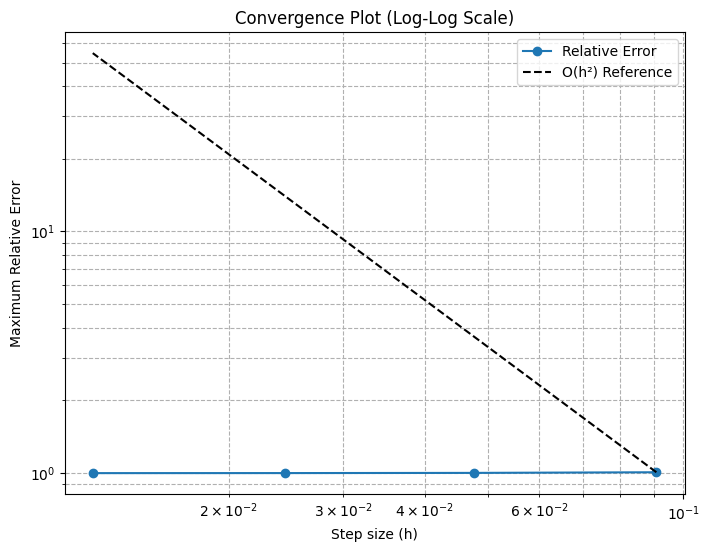


Estimated Convergence Rates:
From grid size 10x10 to 20x20: Rate ≈ 0.01
From grid size 20x20 to 40x40: Rate ≈ 0.00
From grid size 40x40 to 80x80: Rate ≈ 0.00


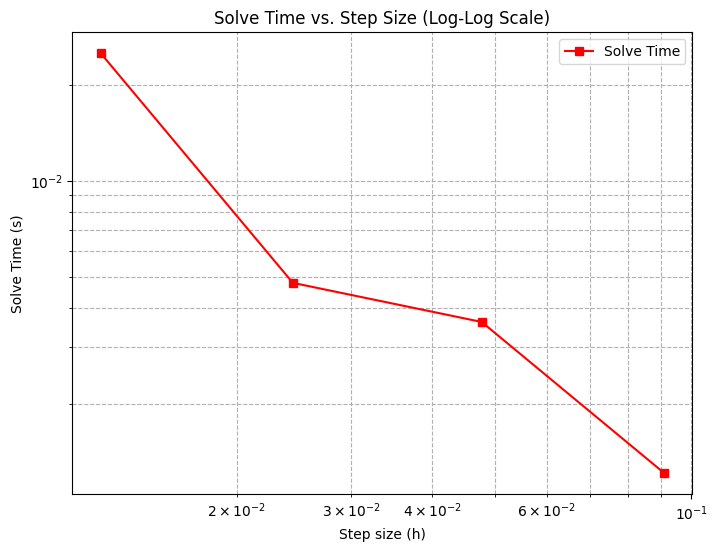

In [28]:
def main():
    """
    Main function to perform validation and convergence study.
    """
    perform_convergence_study()

if __name__ == "__main__":
    main()